In [63]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data Loading & Cleaning

In [64]:
product = pd.read_csv("/project/data/CASP004-01/CASP004-01_bag-product-setup.csv")
product.head(5)

,org_ID,trial_ID,bag_color,bag_set,replicates,bag_composition_tyoe,product_name,product_brand,description,composition,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,44547.0,44547-01-21,Green,A,1-3,Baseline,12 oz Hot cup / Soup bowl,BÉSICS®,12 oz Hot cup / Soup bowl,"Paper, PLA lining, adhesive, ink",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44547.0,44547-01-21,Green,A,1-3,Baseline,Hot cup lid,BÉSICS®,Hot cup lid,CPLA based bio-polymer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44547.0,44547-01-21,Green,A,1-3,Baseline,16 oz PLA cold cup,Greenware®,16 oz PLA cold cup,"PLA, ink",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44547.0,44547-01-21,Green,A,1-3,Baseline,Cutlery,BÉSICS®,Cutlery,"CPLA, talc",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44547.0,44547-01-21,Green,A,1-3,Baseline,"PLA-lined fibre bowl, white",BÉSICS®,"PLA-lined fibre bowl, white","PLA, bagasse (sugarcane fibre)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
trial = pd.read_csv("/project/data/CASP004-01/CASP004-01_test-summary-per-bag.csv")
trial.head(5)

,org_ID,trial_ID,bag_color,bag_ID,stage,weather,moisture_%,temp_F,bulk_density_lbs_per_cy,bulk_density_g_per_cm3,...,bag_intact,bag_depth,product_name,photo_available,fragment_size,weight_1,weight_2,weight_3,weight_mean_g,Product Notes
0,44547.0,44547-01-21,Green,A-1,Start,Windy,51.0,65-80,754.0,0.29,...,True,Top depth,12 oz Hot cup / Soup bowl,Y,"3’’ diameter, 2.5’’ H",8.12,8.10,8.12,8.11,NaN
1,44547.0,44547-01-21,Green,A-1,Start,Windy,51.0,65-80,754.0,0.29,...,True,Top depth,Hot cup lid,Y,"3.5’’ diameter, 0.5’’ H",3.58,3.58,3.56,3.57,NaN
2,44547.0,44547-01-21,Green,A-1,Start,Windy,51.0,65-80,754.0,0.29,...,True,Top depth,16 oz PLA cold cup,Y,"2.5’’ diameter at base, 4’’ diameter at mouth,...",14.58,14.58,14.58,14.58,NaN
3,44547.0,44547-01-21,Green,A-1,Start,Windy,51.0,65-80,754.0,0.29,...,True,Top depth,Cutlery,Y,6.5’’ x 1.53’’ (max) x 3/8’’,4.75,4.75,4.75,4.75,NaN
4,44547.0,44547-01-21,Green,A-1,Start,Windy,51.0,65-80,754.0,0.29,...,True,Top depth,"PLA-lined fibre bowl, white",Y,5.5’’ x 5.5’’ x 2’’,10.52,10.52,10.51,10.52,NaN


In [66]:
# merge data
merged = pd.merge(product, trial, on='product_name', how='outer')

# create bag_missing
merged['bag_lost'] = merged['Product Notes'].isin(['Bag 5 not found', 'Bag 6 not found'])
merged['items_stuck_together'] = merged['Product Notes'].isin(['2 fragments, weighed together', 
                                                               'Several items stuck together and not decomposed well'])

# drop junk
columns_to_remove = [col for col in merged.columns if 'Unnamed' in col]
merged.drop(columns_to_remove, axis=1, inplace=True)

columns_to_remove = ['org_ID_x', 'trial_ID_x','bag_color_x', 'bag_set',
                     'replicates','bag_composition_tyoe', 'notes', 'Product Notes',
                     'bulk_density_lbs_per_cy', 'weight_1_x', 'weight_2_x', 'weight_3_x']
merged.drop(columns_to_remove, axis=1, inplace=True)

# rename
merged.rename(columns={'weight_1_y': 'weight_1', 
                       'weight_2_y': 'weight_2', 
                       'weight_3_y': 'weight_3',
                       'weight_mean_g_y': 'weight_mean',
                       'weight_mean_g_x': 'weight_product',
                       'org_ID_y': 'org_ID', 
                       'trial_ID_y': 'trial_ID'}, inplace=True)

# sort out invalid
invalid_conditions = (merged['bag_lost']) | (merged['items_stuck_together'])
merged.loc[invalid_conditions, ['weight_mean', 'weight_1', 'weight_2', 'weight_3']] = "INVALID"

# fill in weight_mean
merged[['weight_1', 'weight_2', 'weight_3']] = merged[['weight_1', 'weight_2', 'weight_3']].apply(pd.to_numeric, errors='coerce').fillna(0)
merged['weight_mean'] = merged[['weight_1', 'weight_2', 'weight_3']].mean(axis=1).round(2)

# crop
merged = merged.iloc[:1043 + 1]

# save csv
merged.to_csv('/project/data/CASP004-01/CASP004-01_merged.csv', index=False)

/tmp/ipykernel_656/1355941800.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'INVALID' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged.loc[invalid_conditions, ['weight_mean', 'weight_1', 'weight_2', 'weight_3']] = "INVALID"


In [67]:
# Find % of composed and % of not composed
merged['%_not_decomposed'] = ((merged['weight_mean'] / merged['weight_product'])*100).round(2)
merged['%_decomposed'] = (100 - merged['%_not_decomposed']).round(2)
print(merged.shape[0])

# Filter out rows where '%_decomposed' and '%_not_decomposed' are not between 0 and 100
merged = merged[(merged['%_not_decomposed'].between(0, 100)) & (merged['%_decomposed'].between(0, 100))]
num_rows_filtered = merged.shape[0]
print(num_rows_filtered)

# save
merged.to_csv('/project/data/CASP004-01/CASP004-01_decompose.csv', index=False)

1044
944


Comparing Weights Pre- and Post- Composting Based On The Product and Stage

/tmp/ipykernel_656/109650043.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stages_ordered = stages.groupby(


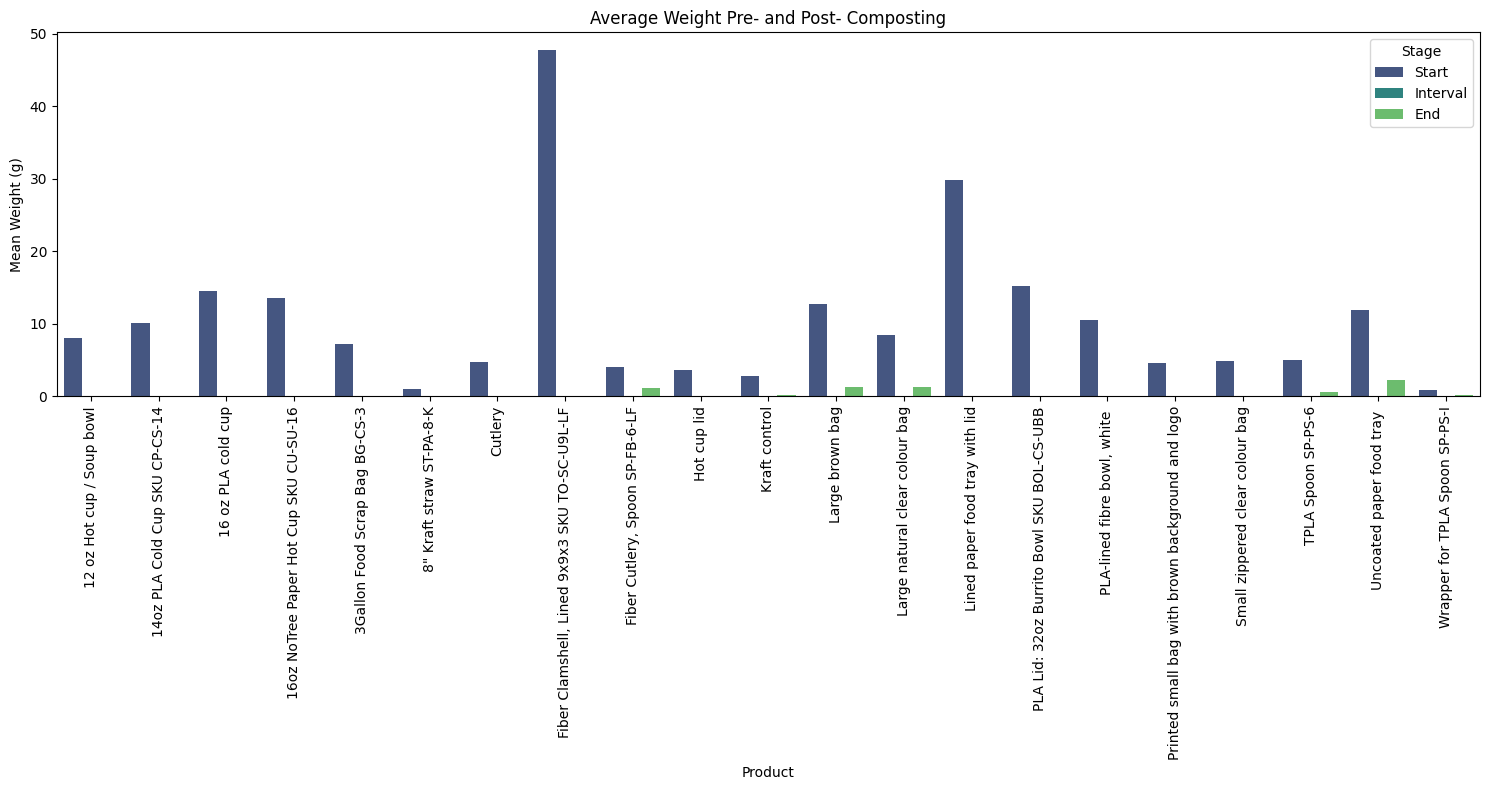

In [77]:
stages = pd.read_csv('/project/data/CASP004-01/CASP004-01_decompose.csv')

# Define the order of the stages
stage_order = pd.CategoricalDtype(
    categories=["Start", "Interval", "End"],
    ordered=True
)
stages['stage'] = stages['stage'].astype(stage_order)

# Group by 'product_name' and 'stage' and calculate the mean weight
stages_ordered = stages.groupby(
    ['product_name', 'stage']
)['weight_mean'].mean().reset_index().round(2)

plt.figure(figsize=(15, 8))
sns.barplot(x='product_name', y='weight_mean', hue='stage', data=stages_ordered, palette="viridis")
plt.title('Average Weight Pre- and Post- Composting')
plt.xlabel('Product')
plt.ylabel('Mean Weight (g)')
plt.xticks(rotation=90)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()

Looking at the %_decomposed and best ways to visualize this metric

In [69]:
decompose = merged[['product_name', 'stage', 'weight_mean', '%_not_decomposed', '%_decomposed']]
decompose.head(10)


,product_name,stage,weight_mean,%_not_decomposed,%_decomposed
0,12 oz Hot cup / Soup bowl,Start,8.11,100.0,0.0
1,12 oz Hot cup / Soup bowl,Start,8.11,100.0,0.0
2,12 oz Hot cup / Soup bowl,Start,8.11,100.0,0.0
3,12 oz Hot cup / Soup bowl,Start,8.11,100.0,0.0
4,12 oz Hot cup / Soup bowl,Start,8.11,100.0,0.0
5,12 oz Hot cup / Soup bowl,Start,8.11,100.0,0.0
6,12 oz Hot cup / Soup bowl,Interval,0.00,0.0,100.0
7,12 oz Hot cup / Soup bowl,Interval,0.00,0.0,100.0
8,12 oz Hot cup / Soup bowl,Interval,0.00,0.0,100.0
9,12 oz Hot cup / Soup bowl,Interval,0.00,0.0,100.0


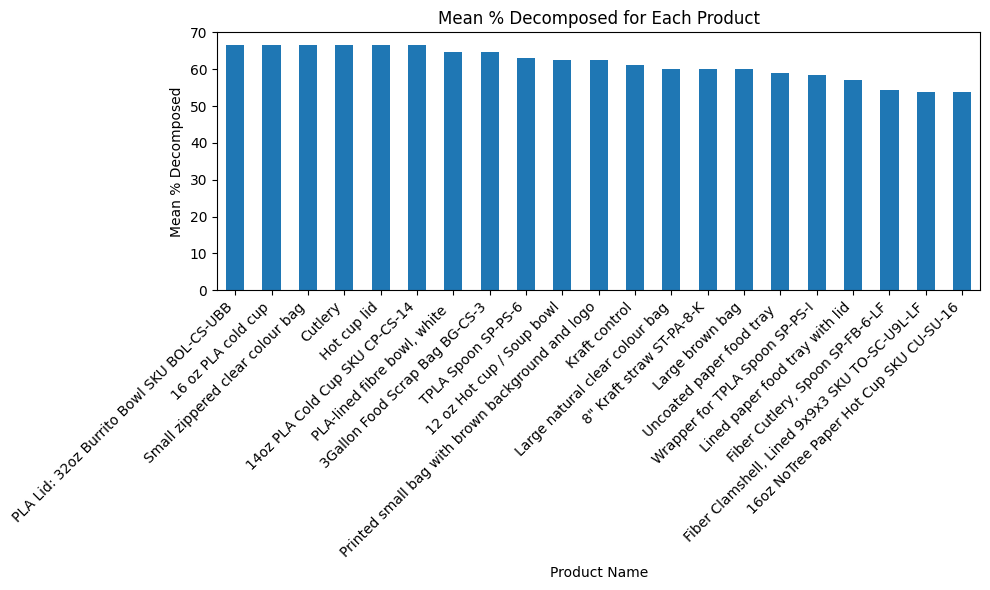

In [74]:
# Grouping the data by 'product_name' and calculating the mean of '%_decomposed'
mean_decomposed = decompose.groupby(
    'product_name'
)['%_decomposed'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mean_decomposed.plot(kind='bar')
plt.title('Mean % Decomposed for Each Product')
plt.xlabel('Product Name')
plt.ylabel('Mean % Decomposed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

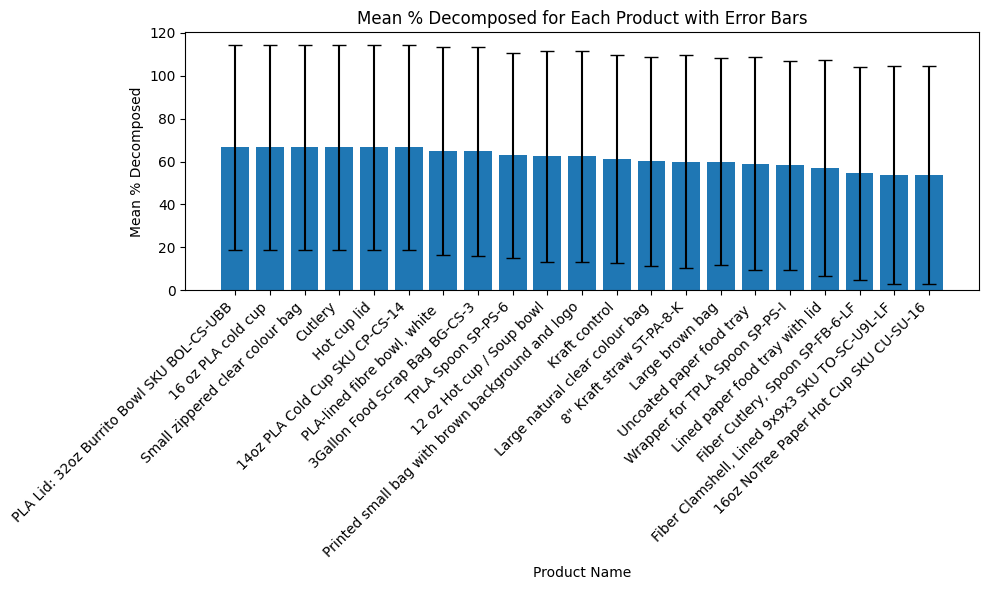

In [96]:
grouped_data = decompose.groupby(
    'product_name'
)['%_decomposed'].agg(['mean', 'std']).sort_values(by='mean', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
plt.title('Mean % Decomposed for Each Product with Error Bars')
plt.xlabel('Product Name')
plt.ylabel('Mean % Decomposed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_656/82942057.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='product_name', y='%_decomposed', data=filtered_decompose, palette="viridis")


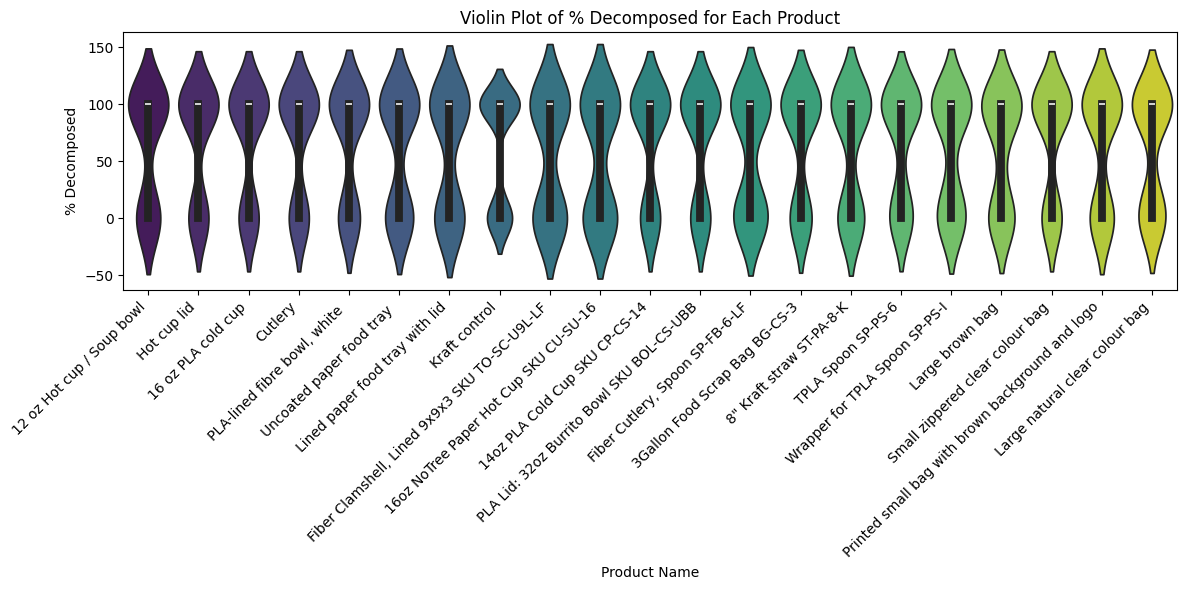

In [82]:
filtered_decompose = decompose[(decompose['%_decomposed'] >= 0) 
                               & (decompose['%_decomposed'] <= 100)]

plt.figure(figsize=(12, 6))
sns.violinplot(x='product_name', y='%_decomposed', data=filtered_decompose, palette="viridis")
plt.title('Violin Plot of % Decomposed for Each Product')
plt.xlabel('Product Name')
plt.ylabel('% Decomposed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Note: Violin plots combine box plots and KDE, the extension of the violin plots beyond
# the range of the data (0-100) is a visual artifact of the smoothening algorhithm 

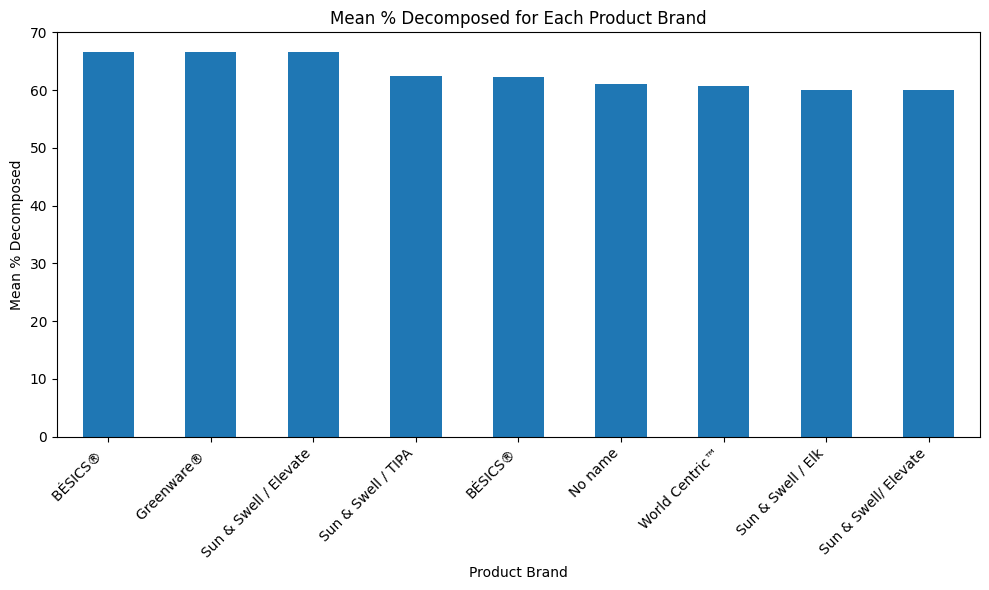

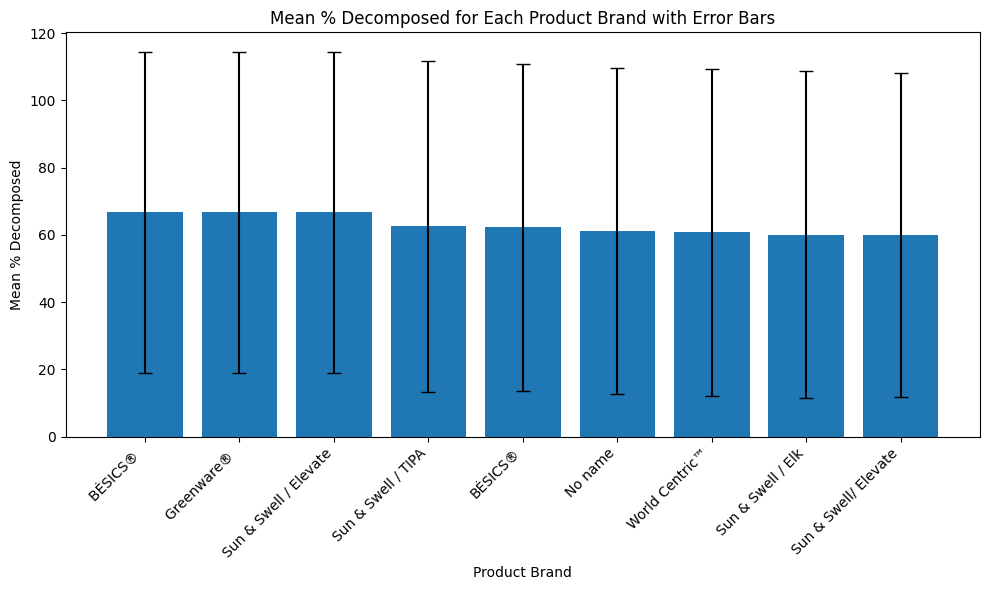

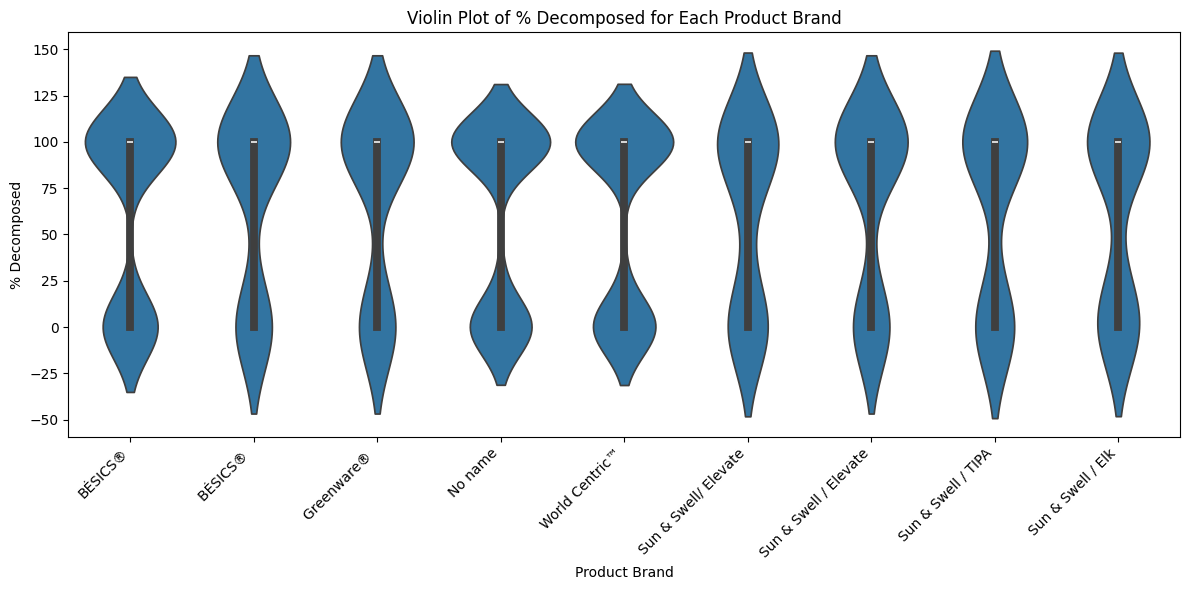

In [98]:
# Repeat analysis for 'product_brand'
decompose = pd.read_csv('/project/data/CASP004-01/CASP004-01_decompose.csv')
brand_grouped = decompose.groupby('product_brand')['%_decomposed'].agg(['mean', 'std'])
brand_grouped_sorted = brand_grouped.sort_values(by='mean', ascending=False)

# Bar Plot
plt.figure(figsize=(10, 6))
brand_grouped_sorted['mean'].plot(kind='bar')
plt.title('Mean % Decomposed for Each Product Brand')
plt.xlabel('Product Brand')
plt.ylabel('Mean % Decomposed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar Plot with Error Bars
plt.figure(figsize=(10, 6))
plt.bar(brand_grouped_sorted.index, brand_grouped_sorted['mean'], yerr=brand_grouped_sorted['std'], capsize=5)
plt.title('Mean % Decomposed for Each Product Brand with Error Bars')
plt.xlabel('Product Brand')
plt.ylabel('Mean % Decomposed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='product_brand', y='%_decomposed', data=decompose)
plt.title('Violin Plot of % Decomposed for Each Product Brand')
plt.xlabel('Product Brand')
plt.ylabel('% Decomposed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()